# Help Protect the Great Barrier Reef

![](https://i.guim.co.uk/img/media/2a50a331f09cc3176905c05d8d8d381246727e20/0_372_2480_1488/master/2480.jpg?width=620&quality=85&auto=format&fit=max&s=2706cdbdb70a1710196da9c618bbbcc6)

## Goal of the Competition
The goal of this competition is to accurately identify starfish in real-time by building an object detection model trained on underwater videos of coral reefs.

Your work will help researchers identify species that are threatening Australia's Great Barrier Reef and take well-informed action to protect the reef for future generations.

## Context
Australia's stunningly beautiful Great Barrier Reef is the world’s largest coral reef and home to 1,500 species of fish, 400 species of corals, 130 species of sharks, rays, and a massive variety of other sea life.

Unfortunately, the reef is under threat, in part because of the overpopulation of one particular starfish – the coral-eating crown-of-thorns starfish (or COTS for short). Scientists, tourism operators and reef managers established a large-scale intervention program to control COTS outbreaks to ecologically sustainable levels.

**Imports**

In [1]:
import os, io, pathlib
import tensorflow as tf
import tensorflow_addons as tfa
import ast
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from PIL import Image
import matplotlib.pyplot as plt

**Some Functions borrowed from Keras retinanet (see references section for more details)**

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
SEED = 2021

In [4]:
root = '../data'
data_dir = os.path.join(root,'train_images')
data_dir = pathlib.Path(data_dir)

**Load Data**

In [5]:
train_data = pd.read_csv(os.path.join(root,'train.csv'))
test_data = pd.read_csv(os.path.join(root,'test.csv'))
train_data['image'] = train_data.apply(lambda x:  os.path.join(data_dir,f'video_{x.video_id}', f'{x.video_frame}.jpg'),axis=1)
train_data['annotations'] = train_data['annotations'].apply(lambda x: ast.literal_eval(x))
train_data['has_starfish'] = train_data['annotations'].apply(len).gt(0).astype(int)
train_data = pd.concat(train_data.apply(lambda x: pd.DataFrame.from_dict(
    [
        {
            'image': x.image, 
            'has_starfish': x.has_starfish, 
            'x1': y['x'], 
            'y1': y['y'], 
            'x2': y['x'] + y['width'], 
            'y2': y['y'] + y['height'],
            'w': y['width'],
            'h': y['height']
        
        } for y in x.annotations
    ]
    if len(x.annotations) > 0 else [
       {
            'image': x.image, 
            'has_starfish': x.has_starfish, 
            'x1': 0,
            'y1': 0,
            'x2': 0,
            'y2': 0,
            'w': 0,
            'h': 0,
        } 
    ]
    
    ),axis=1).values, ignore_index=True)

train_data = train_data.merge(train_data.image.value_counts().to_frame().reset_index().rename(columns={'index':'image','image':'count'}),on='image',how='left')
train_data[:3]

,image,has_starfish,x1,y1,x2,y2,w,h,count
0,..\data\train_images\video_0\0.jpg,0,0,0,0,0,0,0,1
1,..\data\train_images\video_0\1.jpg,0,0,0,0,0,0,0,1
2,..\data\train_images\video_0\2.jpg,0,0,0,0,0,0,0,1


In [6]:
train,test = train_test_split(train_data, test_size=0.2, random_state=SEED, stratify=train_data['has_starfish'])

In [7]:
IMG_HEIGHT = 299
IMG_WIDTH=299
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 512

@tf.function
def load_img(img_path, label, bbox):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    
    raw_img_height, raw_img_width = tf.shape(image)[0], tf.shape(image)[1]
    scale_x = tf.cast((raw_img_width / IMG_WIDTH), tf.float32)
    scale_y = tf.cast((raw_img_height / IMG_HEIGHT), tf.float32)
    
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    
    bbox = tf.cast(bbox, tf.float32)
    bbox = tf.divide(bbox, [scale_x, scale_y, scale_x, scale_y])
    
    return image,{'label': label, 'bbox': bbox}


trainloader = tf.data.Dataset.from_tensor_slices((train.image, train.has_starfish, train[['x1', 'y1', 'x2', 'y2']].values))
testloader = tf.data.Dataset.from_tensor_slices((test.image, test.has_starfish, test[['x1', 'y1', 'x2', 'y2']].values))

trainloader = (
    trainloader
    .map(load_img, num_parallel_calls=AUTO)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
testloader = (
    testloader
    .map(load_img, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [8]:
for x in trainloader.take(1).as_numpy_iterator():
    print(pd.DataFrame.from_dict([x[-1]]).T)

                                                       0
label  [1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, ...
bbox   [[1.6351563, 205.97778, 10.978907, 222.5889], ...


In [9]:
def get_model():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
    
    fe_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    fe_model.trainable = False
    
    base_clf = tf.keras.layers.Flatten()(fe_model.output)
    base_reg = tf.keras.layers.GlobalAveragePooling2D()(fe_model.output)
   
    classifier_head = tf.keras.layers.Dropout(0.3)(base_clf)
    classifier_head = tf.keras.layers.Dense(1, activation='sigmoid', name='label')(classifier_head)

    reg_head = tf.keras.layers.Dense(64, activation='relu')(base_reg)
    reg_head = tf.keras.layers.Dense(32, activation='relu')(reg_head)
    reg_head = tf.keras.layers.Dense(4, activation='relu', name='bbox')(reg_head)

    return tf.keras.Model(inputs=[fe_model.inputs], outputs=[classifier_head, reg_head])


In [10]:
tf.keras.backend.clear_session()
model = get_model()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.007),
    loss={
      'label': 'binary_crossentropy', 
      'bbox': 'mse'
      }, 
    metrics={
      'label': 'accuracy', 
      'bbox': tf.metrics.RootMeanSquaredError()
      },
    )

# print(model.summary())

model.fit(trainloader, 
          epochs=10, 
          validation_data=testloader, 
          callbacks=[early_stopper], 
          batch_size=BATCH_SIZE
        )

Epoch 1/10
48/48 [==============================] - 50s 843ms/step - loss: 7028.6792 - label_loss: 207.0685 - bbox_loss: 6821.6108 - label_accuracy: 0.7108 - bbox_root_mean_squared_error: 82.5930 - val_loss: 6105.6929 - val_label_loss: 24.8930 - val_bbox_loss: 6080.7993 - val_label_accuracy: 0.8066 - val_bbox_root_mean_squared_error: 77.9795
Epoch 2/10
48/48 [==============================] - 35s 682ms/step - loss: 5925.5503 - label_loss: 11.7695 - bbox_loss: 5913.7827 - label_accuracy: 0.8704 - bbox_root_mean_squared_error: 76.9011 - val_loss: 5727.0571 - val_label_loss: 9.5973 - val_bbox_loss: 5717.4595 - val_label_accuracy: 0.8766 - val_bbox_root_mean_squared_error: 75.6139
Epoch 3/10
48/48 [==============================] - 35s 679ms/step - loss: 5620.0845 - label_loss: 5.3566 - bbox_loss: 5614.7290 - label_accuracy: 0.9128 - bbox_root_mean_squared_error: 74.9315 - val_loss: 5484.9497 - val_label_loss: 7.6297 - val_bbox_loss: 5477.3198 - val_label_accuracy: 0.8752 - val_bbox_root_m

In [11]:
def predict(image_path,model):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

    p_label, p_bbox = model.predict(image[tf.newaxis, ...])
    
    return p_label, p_bbox

In [12]:
def scale_down_bbox(rw,rh,bbox):
    scale_x = rw / IMG_WIDTH
    scale_y = rh / IMG_HEIGHT
    bbox = np.array(bbox)
    return bbox / np.array([scale_x, scale_y, scale_x, scale_y])

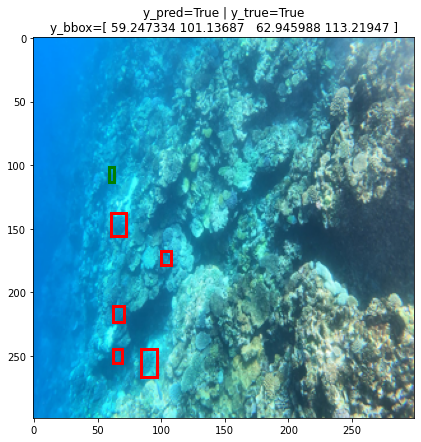

In [24]:
plt.figure(figsize=(7,7))
# draw sampel
sample = train.sample(1)
true_label = sample.has_starfish.values[0]
img_path = sample.image.values[0]
bboxes = train_data.loc[(train_data.image == img_path) & (train_data.has_starfish == True)][['x1', 'y1', 'x2', 'y2']].values

# plot image and bbox
img = Image.open(img_path)
bboxes = [ scale_down_bbox(img.width, img.height, bbox) for bbox in bboxes]
img = img.resize((IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)

# predict and plot bbox 
gca = plt.gca()
for bbox in bboxes:
    gca.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='red', linewidth=3))
y_label, y_bbox = predict(img_path, model)
y_label = y_label[0]
y_bbox = y_bbox[0]
plt.title(f'y_pred={bool(y_label)} | y_true={bool(true_label)}\ny_bbox={y_bbox}');
if bool(y_label):
    gca.add_patch(plt.Rectangle((y_bbox[0], y_bbox[1]), y_bbox[2] - y_bbox[0], y_bbox[3] - y_bbox[1], fill=False, edgecolor='green', linewidth=3));

In [14]:
y_pred_label, y_pred_bbox = model.predict(testloader)
y_pred = y_pred_label[:,0] > .5
print(metrics.classification_report(test.has_starfish, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3716
           1       0.98      0.94      0.96      2380

    accuracy                           0.97      6096
   macro avg       0.97      0.97      0.97      6096
weighted avg       0.97      0.97      0.97      6096



**Resources**

- [Install Tensorflow M1](http://blog.wafrat.com/installing-tensorflow-2-5-and-jupyter-lab-on-m1/)
- [Load and preprocess images](https://www.tensorflow.org/tutorials/load_data/images)
- [Object Localization on synthetic MNIST dataset](https://colab.research.google.com/drive/1LWbgjNbQLQHgfY2WH0lKBEFRIZXdqT86?usp=sharing#scrollTo=7A5EH7xp2x0i)
- [Keras Retinanet](https://keras.io/examples/vision/retinanet/)
- [Generalized Intersection over Union: A Metric and A Loss for Bounding Box
Regression](https://giou.stanford.edu/GIoU.pdf)
- [tfa.losses.GIoULoss](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/GIoULoss)